## Тестовая реализация RealNVP с использованием pytorch

К сожалению, я не смог успешно интегрировать собственную версию autograd в реализацию realnvp прошлой версии данного тестового задания, поэтому в целях обучения решил имплементировать модель с уже готовым фреймворком (pytorch; внутри он использует autograd).

### Подготовим ноутбук к работе

In [ ]:
!pip install --upgrade --quiet wandb

In [ ]:
import io
import os
import torch
import wandb
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import torch.nn as nn
import importlib as imp
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader

In [ ]:
# Зафиксируем состояние системы

rd_seed = 21

random.seed(rd_seed)
os.environ['PYTHONHASHSEED'] = str(rd_seed)
np.random.seed(rd_seed)

torch.manual_seed(rd_seed)

if torch.backends.mps.is_available():
    torch.mps.manual_seed(rd_seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(rd_seed)

In [ ]:
def select_device():
    if torch.cuda.is_available():
        return 'cuda'
    elif torch.backends.mps.is_available():
        return 'mps'
    return 'cpu'

In [ ]:
# Установим значения для работы модели

device = torch.device(select_device())
print(f'Using device: {device}')

mode = {
    'train': True,
    'load': False,
    'inference': True,
    'checkpoints': True,
}

model_options = {
    'n_width': 18,
    'n_coupling': 14,
    'input_width': 1
}

train_options = {
    'lr': 0.0007,
    'batch_size': 1000,
    'epochs': 120,

    'device': device
}

run_options = {
    'version': 1,
    'wandb_token': None,

    'mean': (0, 0),
    'cov': [[1, 0.8], [0.8, 1]]
}

run_options['trainy_name'] = f'realnvp_poc_v{run_options["version"]}'

Using device: cuda


In [ ]:
# Установим секретные значения


def load_secret(k):
    # Если окружение - kaggle
    try:
        secrets = imp.import_module('kaggle_secrets')
        sc = secrets.UserSecretsClient()

        return sc.get_secret(k)

    except:
        ...

    # Если локальное окружение
    if k in os.environ:
        return os.environ[k]

    return input(f'value of {k}: ')


run_options['wandb_token'] = load_secret('WANDB_API')

value of WANDB_API: 47a9cedc1e563f7a5ea07755d62595906acd9928


In [ ]:
# Инициализируем подключение к wandb

wandb.login(key=run_options['wandb_token'], relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Реализуем модель, используя PyTorch

In [ ]:
def w_init(model):
    # TODO: попробовать pytorch/овый batchnorm; инициализировать его веса здесь
    ...


class SimplifiedRNVP(nn.Module):
    def __init__(self, model_options):
        super(SimplifiedRNVP, self).__init__()

        self.n_coupling = model_options['n_coupling']


        # В целях упрощения, буду использовать простую полносвязную сеть а не resnet
        get_backbone = lambda iw: nn.Sequential(OrderedDict({
            'l1' : nn.Linear(iw, model_options['n_width']),
            'a1':  nn.ReLU(),
            'l2':  nn.Linear(model_options['n_width'], model_options['n_width']),
            'a2':  nn.ReLU(),
            'l3':  nn.Linear(model_options['n_width'], model_options['n_width']),
            'a3':  nn.ReLU(),
            'l4':  nn.Linear(model_options['n_width'], iw),
            't1':  nn.Tanh()
        }))


        # Операции изменения размерности и трансформирования
        self.s = nn.ModuleList([
            get_backbone(model_options['input_width'])
                for _ in range(self.n_coupling)
        ])

        self.t = nn.ModuleList([
            get_backbone(model_options['input_width'])
                for _ in range(self.n_coupling)
        ])


        self.scale_options = nn.Parameter(data=torch.randn(self.n_coupling), requires_grad=True)

    def forward(self, X):
        if self.training:
            y1, y2 = X[:, :1], X[:, 1:]

            # Проходимся по всем слоям
            jacobian_determinant_components = []

            for level in range(self.n_coupling):
                x1, x2 = y1, y2

                if level % 2 == 0:
                    y1 = x1

                    curr_s = self.scale_options[level] * self.s[level](x1)
                    y2 = torch.exp(curr_s) * x2 + self.t[level](x1)

                else:
                    y2 = x2

                    curr_s = self.scale_options[level] * self.s[level](x2)
                    y1 = torch.exp(curr_s) * x1 + self.t[level](x2)

                jacobian_determinant_components.append(curr_s)

            joined_components = torch.cat(jacobian_determinant_components)

            return torch.cat([y1, y2], 1), joined_components

        else:
            x1, x2 = X[:, :1], X[:, 1:]

            for level in reversed(range(self.n_coupling)):
                y1, y2 = x1, x2

                if level % 2 == 0:
                    x1 = y1

                    curr_s = self.scale_options[level] * self.s[level](y1)
                    x2 = (y2 - self.t[level](y1)) * torch.exp(-curr_s)

                else:
                    x2 = y2

                    curr_s = self.scale_options[level] * self.s[level](y2)
                    x1 = (y1 - self.t[level](y2)) * torch.exp(-curr_s)

            return torch.cat([x1, x2], 1)

    def save(self):
        ...

    def load(self, name: str):
        ...

    @staticmethod
    def loss(y, det_comps, batch_size):
        gp = -torch.sum(0.5 * y**2)
        det = torch.sum(det_comps)

        return torch.div(-(gp + det), batch_size)

### Определим датасет

In [ ]:
X, _ = make_moons(
    n_samples=10000,
    noise=0.05,
    random_state=rd_seed
)

df = pd.DataFrame({'x_1': X[:, 0], 'x_2': X[:, 1]})

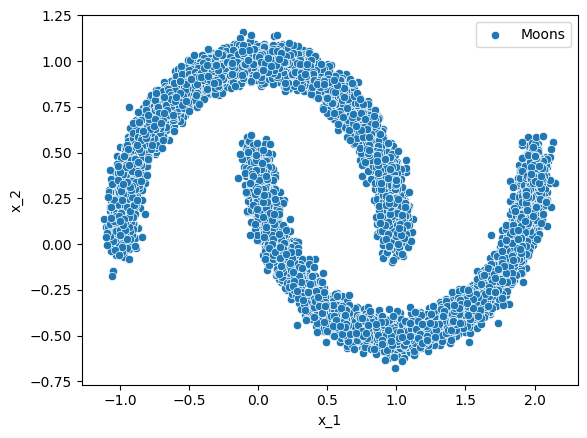

In [ ]:
sns.scatterplot(data=df, x='x_1', y='x_2', label='Moons')
plt.show()

In [ ]:
train_dl = DataLoader(
    df.values,
    batch_size=train_options['batch_size'],
    shuffle=True,
)

In [ ]:
def train_handle(model, wandb, dl, train_opts):
    global run_options

    sample_X = torch.Tensor(next(iter(dl))).to(device)
    sample_Z = torch.Tensor(np.random.multivariate_normal(run_options['mean'], run_options['cov'], 400))

    optim = torch.optim.Adam(model.parameters(), lr=train_opts['lr'])
    def train_loop(epoch):
        model.train()

        loss_list = []

        display = tqdm(dl)

        for s_batch in display:
            s_batch = torch.Tensor(s_batch).to(device).float()

            y, det_parts = model(s_batch)
            optim.zero_grad()

            curr_loss = SimplifiedRNVP.loss(y, det_parts, train_opts['batch_size'])

            curr_loss.backward()
            optim.step()


            curr_loss = curr_loss.detach().to('cpu')
            display.set_description(f'Loss: {curr_loss}')

            loss_list.append(curr_loss)

        return loss_list

    for epoch in range(train_opts['epochs']):
        losses = train_loop(epoch)

        with torch.no_grad():
            model.train()

            Z_changing, _ = model(torch.Tensor(X).to(device))
            Z_changing = Z_changing.cpu().numpy()


            model.eval()

        fig, ax = plt.subplots()
        ax.scatter(Z_changing[:, 0], Z_changing[:, 1])
        ax.set_title(f"Latent Space at Epoch: {epoch}")


        wandb.log({
            'mean_loss': np.mean(losses),
            'epoch': epoch,

        })

        wandb.log({"latent_space": [wandb.Image(fig, caption=f"Epoch {epoch}")]}, step=epoch+1)
        plt.close(fig)


In [ ]:
model = SimplifiedRNVP(model_options)
model.apply(w_init)
model.to(device)

SimplifiedRNVP(
  (s): ModuleList(
    (0-13): 14 x Sequential(
      (l1): Linear(in_features=1, out_features=18, bias=True)
      (a1): ReLU()
      (l2): Linear(in_features=18, out_features=18, bias=True)
      (a2): ReLU()
      (l3): Linear(in_features=18, out_features=18, bias=True)
      (a3): ReLU()
      (l4): Linear(in_features=18, out_features=1, bias=True)
      (t1): Tanh()
    )
  )
  (t): ModuleList(
    (0-13): 14 x Sequential(
      (l1): Linear(in_features=1, out_features=18, bias=True)
      (a1): ReLU()
      (l2): Linear(in_features=18, out_features=18, bias=True)
      (a2): ReLU()
      (l3): Linear(in_features=18, out_features=18, bias=True)
      (a3): ReLU()
      (l4): Linear(in_features=18, out_features=1, bias=True)
      (t1): Tanh()
    )
  )
)

In [ ]:
if mode['load']:
    load_handle(model)


if mode['train']:

    project = "imsh_test"
    display_name = run_options['trainy_name']

    wandb.init(
        project=project,
        name=display_name,
        config={
            'model': model_options,
            'train': train_options
        }
    )


    exh_list = train_handle(model, wandb, train_dl, train_options)

    wandb.finish(quiet=True)

Loss: -1.540481686592102: 100%|██████████| 10/10 [00:00<00:00, 27.63it/s]


### Отрисуем графики, как в статье arxiv

In [ ]:
with torch.no_grad():
    model.train(True)
    Z, _ = model(torch.Tensor(X).to(device))
    Z = Z.cpu().numpy()

    OG_latent_space = pd.DataFrame({
        'z1': Z[:, 0],
        'z2': Z[:, 1]
    })


    model.eval()

    Z_samples = torch.Tensor(np.random.multivariate_normal(run_options['mean'], run_options['cov'], 400))
    Z_samples_plot = pd.DataFrame({
        'z1': Z_samples[:, 0],
        'z2': Z_samples[:, 1]
    })


    X_samples = model(Z_samples.to(device)).detach().cpu().numpy()


    X_new_samples = pd.DataFrame({
        'x1': X_samples[:, 0],
        'x2': X_samples[:, 1]
    })


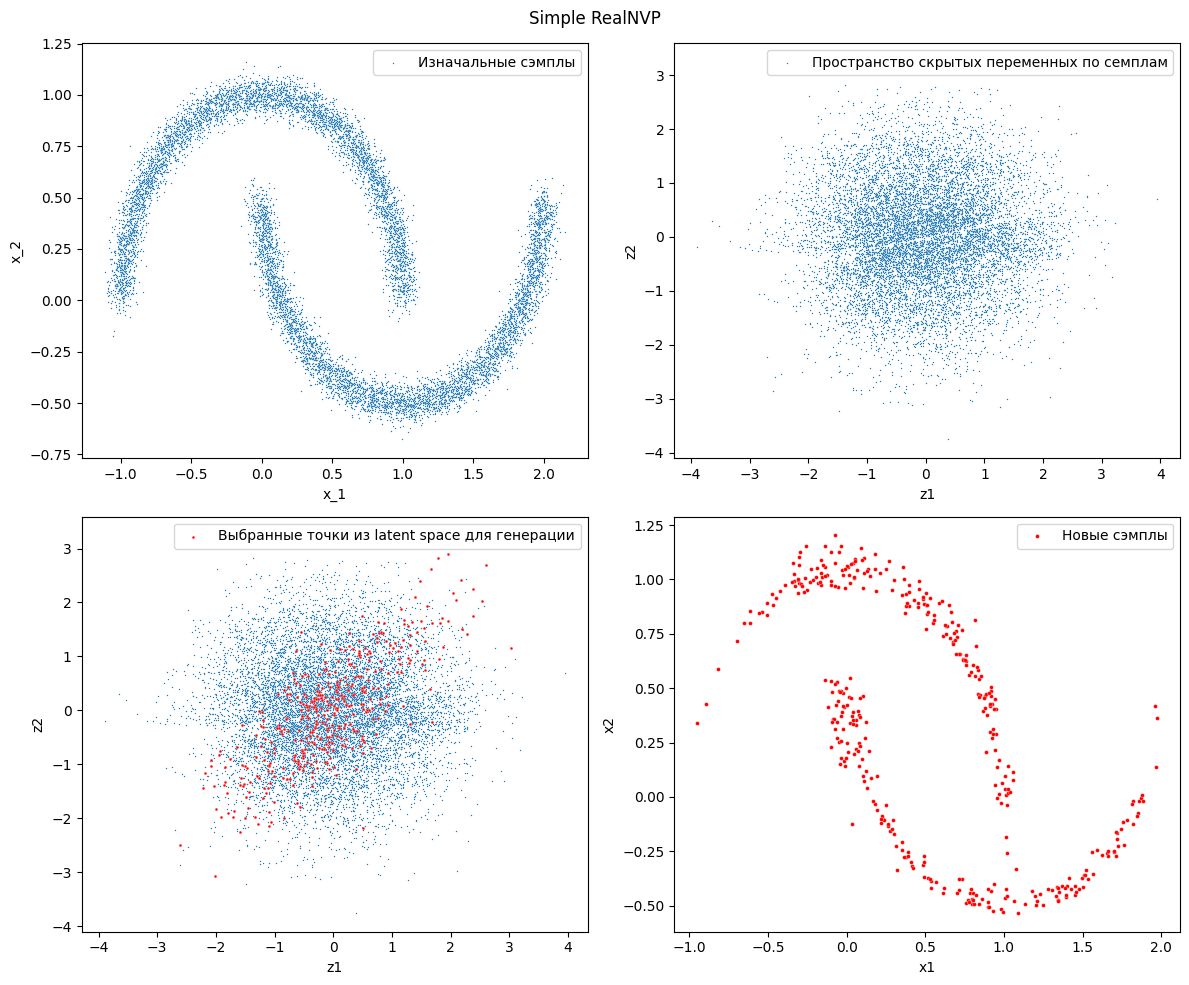

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,10))


sns.scatterplot(data=df, x='x_1', y='x_2', s=1, label='Изначальные сэмплы', ax=ax[0][0])

sns.scatterplot(data=OG_latent_space, x='z1', y='z2', s=1, label='Пространство скрытых переменных по семплам', ax=ax[0][1])

sns.scatterplot(data=OG_latent_space, x='z1', y='z2', s=1, ax=ax[1][0])
sns.scatterplot(data=Z_samples_plot, x='z1', y='z2', s=4, label='Выбранные точки из latent space для генерации', ax=ax[1][0], color='red')

sns.scatterplot(data=X_new_samples, x='x1', y='x2', s=8, label='Новые сэмплы', ax=ax[1][1], color='red')


plt.suptitle('Simple RealNVP')
plt.tight_layout()
plt.show()

In [ ]:
api = wandb.Api()

run = api.run("ai-gigachads/imsh_test/6i52penm")
run

<Run ai-gigachads/imsh_test/6i52penm (finished)>

### Источники:
- https://arxiv.org/pdf/1605.08803.pdf
- https://bjlkeng.io/posts/normalizing-flows-with-real-nvp/